In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
from scipy.ndimage.interpolation import shift
def returns(data): ## compute daily log returns
    N=len(data)
    #r=np.array((N,))
    r = np.log(data) - np.log(data.shift(1))
    #r = r.dropna()
    r = r[1:N]
    return r

[*********************100%***********************]  1 of 1 completed


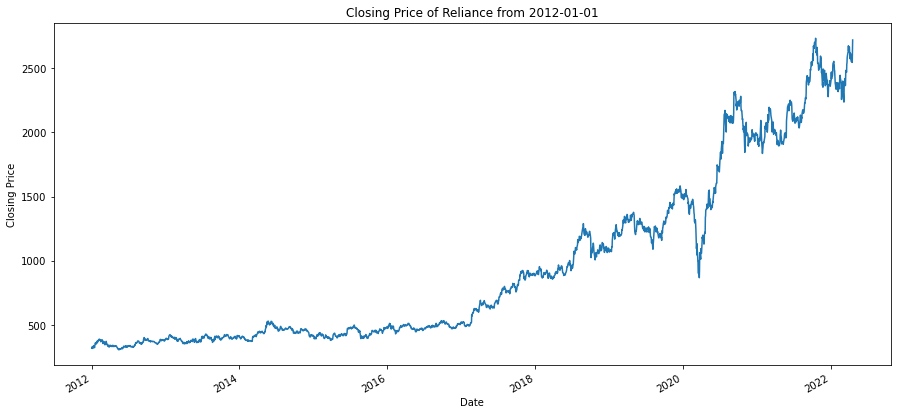

In [84]:
import yfinance as yf
data = yf.download('RELIANCE.NS',start="2012-01-01",end="2022-04-21") ##Reliance 10 years historical data
data['Adj Close'].plot(figsize = (15,7))
plt.title("Closing Price of Reliance from 2012-01-01")
plt.ylabel('Closing Price')
plt.savefig('Rel_closing prices.png')
price = data['Adj Close']

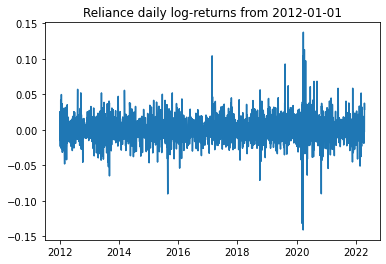

In [48]:
returns_data = returns(price)
plt.plot(data.index[1:],returns_data)
plt.title('Reliance daily log-returns from 2012-01-01')
plt.savefig('Rel_daily_log_returns')

In [49]:
## Reliance statistics
from scipy.stats import kurtosis,skew
print(np.mean(returns_data))
print(np.std(returns_data))
print(skew(returns_data))
print(kurtosis(returns_data,fisher=False))

0.0008395944238393324
0.017916691941839973
0.07607719588117369
10.036623392137294


In [50]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(returns_data)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
#print('critical values at different levels:')
#for k, v in res[4].items():
   # print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -12.402804
p-value: 0.000000
critical values at different levels:
	1%: -3.433
	5%: -2.863
	10%: -2.567


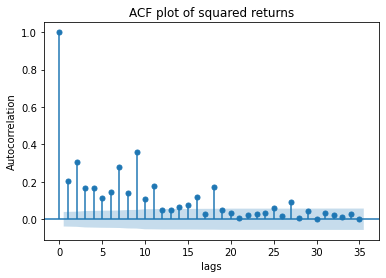

In [78]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_acf((returns_data**2))## checking for correlation
plt.xlabel('lags')
plt.ylabel('Autocorrelation')
plt.title('ACF plot of squared returns')
#plot_pacf((returns_data)**2)
#plt.xlabel('lags')
#plt.ylabel('Partial autocorrelation')
#plt.title('PACF plot of squared returns')
plt.savefig('acf sq returns.png')
plt.show()

In [52]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(returns_data**2,lags=5, return_df=True)

,lb_stat,lb_pvalue
1,108.851780,1.748866e-25
2,344.543617,1.525120e-75
3,413.984701,2.069387e-89
4,485.177767,1.075583e-103
5,516.835099,1.853743e-109


In [53]:
def Garch(para,returns): ## compute the volatilities, input parameters = (omega,a,b) 
    N = len(returns)
    omega,a,b = para[0:3]  ## mean = 0(assumption)
    cond_variance = np.zeros((N,))  ##array to store the volatilities
    #long_run_variance = omega/(1-a-b)
    cond_variance[0] = np.std(returns)**2 ## initialising cond_variance
    #cond_variance[0] = long_run_variance ## initialising cond_variance
    for i in range(1,N):
        cond_variance[i] = omega + a*(returns[i-1])**2 + b*(cond_variance[i-1])    
    return cond_variance ## sigma_squared values
from scipy.special import gamma
def neg_log_likelihood(para,returns,noise): ## computes negative of log-likelihood which will be minimized using scipy.optimise.minimise  
    N= len(returns)                   ## for estimating the parameters.
    cond_variance = Garch(para,returns)
    if noise == 'normal':
        ll = -0.5*sum([np.log(2*(np.pi)) + np.log(cond_variance[j]) + returns[j]**2/cond_variance[j] for j in range(N)])
    elif noise == 't':
        nu = para[3]
        c = np.log([gamma((nu+1)/2)/(gamma(nu/2)*(np.pi*(nu-2))**0.5)])
        ll = c*N - sum([np.log((cond_variance[j])**0.5) for j in range(N)]) - ((nu+1)/2)*sum([np.log(1+(returns[j]**2/((nu-2)*(cond_variance[j])))) for j in range(N)])
    return (-ll)

Taking the noise as Gaussian

In [73]:
from scipy.optimize import minimize
bounds = ((0.0001,None),(0.0001,0.9999),(0.0001,0.9999)) ## bounds for estimating the parameters
res_gauss = minimize(neg_log_likelihood, (0.1,0.05,0.9),args =(np.array(returns_data)*100,'normal'), method='SLSQP',options={'disp': True})
print(res_gauss)
omega,a,b = res_gauss.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4910.71651057369
            Iterations: 12
            Function evaluations: 63
            Gradient evaluations: 12
     fun: 4910.71651057369
     jac: array([0.03173828, 0.04022217, 0.06378174])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.25662576, 0.08774389, 0.8270224 ])


In [74]:
omega = omega/10000 ## For optimisation purpose the returns were converted into percentage and thus the estimate of omega was scaled by 10000.
print("Estimated parameters : omega={}, a={}, b={}".format(omega,a,b))

Estimated parameters : omega=2.5662575817070782e-05, a=0.08774388640751944, b=0.827022396633026


Gaussian Noise Analysis

In [80]:
cond_variance = Garch((omega,a,b),returns_data)
noise_gauss = np.array(returns_data)/np.sqrt(cond_variance)
print(np.mean(noise_gauss))
print(np.var(noise_gauss))

0.04331689451981331
0.9993750083767231


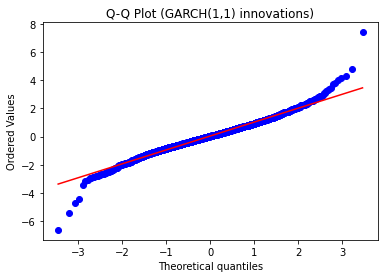

In [85]:
from scipy import stats
stats.probplot(noise_gauss,dist = stats.norm,plot=plt)
plt.title("Q-Q Plot (GARCH(1,1) innovations)")
plt.savefig('qq gaussian.png')

In [87]:
from scipy.stats import jarque_bera,shapiro
print(jarque_bera(noise_gauss))
print(shapiro(noise_gauss))

Jarque_beraResult(statistic=1107.6624170784478, pvalue=0.0)
ShapiroResult(statistic=0.9763551354408264, pvalue=4.233365295321772e-20)


Taking noise as Student's t distribution

In [81]:
from scipy.optimize import minimize
bounds = ((0.0001,None),(0.0001,0.9999),(0.0001,0.9999)) ## bounds for estimating the parameters
res_t = minimize(neg_log_likelihood, (0.1,0.05,0.9,6),args =(np.array(returns_data)*100,'t'), method='SLSQP',options={'disp': True})
print(res_t)
omega_t,a_t,b_t,nu_t = res_t.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: [4825.20600272]
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
     fun: array([4825.20600272])
     jac: array([0.01367188, 0.09973145, 0.06048584, 0.00073242])
 message: 'Optimization terminated successfully'
    nfev: 64
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.16133292, 0.06535864, 0.87934484, 6.0830661 ])


In [82]:
omega_t = omega_t/10000 ## For optimisation purpose the returns were converted into percentage and thus the estimate of omega was scaled by 10000.
print("Estimated parameters : omega={}, a={}, b={}, nu={}".format(omega_t,a_t,b_t,nu_t))

Estimated parameters : omega=1.6133291571398735e-05, a=0.0653586367840284, b=0.8793448360906615, nu=6.083066095083501


Noise analysis(Student's t)

In [83]:
cond_variance_t = Garch((omega_t,a_t,b_t,nu_t),np.array(returns_data))
noise_t = np.array(returns_data)/np.sqrt(cond_variance_t)
print(np.mean(noise_t))
print(np.var(noise_t))

0.04367075558486613
1.012925218237522


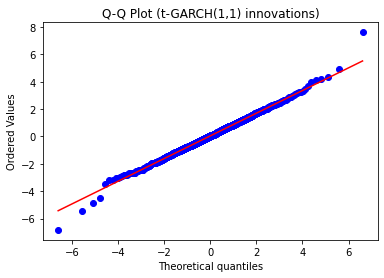

In [86]:
from scipy import stats
stats.probplot(noise_t,dist = stats.t(df=nu_t),plot=plt)
plt.title("Q-Q Plot (t-GARCH(1,1) innovations)")
plt.savefig('qq t residuals.png')
plt.show()

In [88]:
## Implied  Kurtosis from both models
gauss_kurtosis = 3*(1-(a+b)**2)/(1-2*(a**2) - (a+b)**2)
t_kurtosis = (6/(nu_t-4) + 3)*(1-(a_t+b_t)**2)/(1-2*(a_t**2) - (a_t+b_t)**2 - 6*((a_t)**2)/(nu_t-4))
print(gauss_kurtosis)
print(t_kurtosis)

3.312533684972955
7.294554365856918


In [64]:
## From the Q-Q plot and kurtosis values of we see that Student's t distribution performs well as compared to normal distribution for noise. 

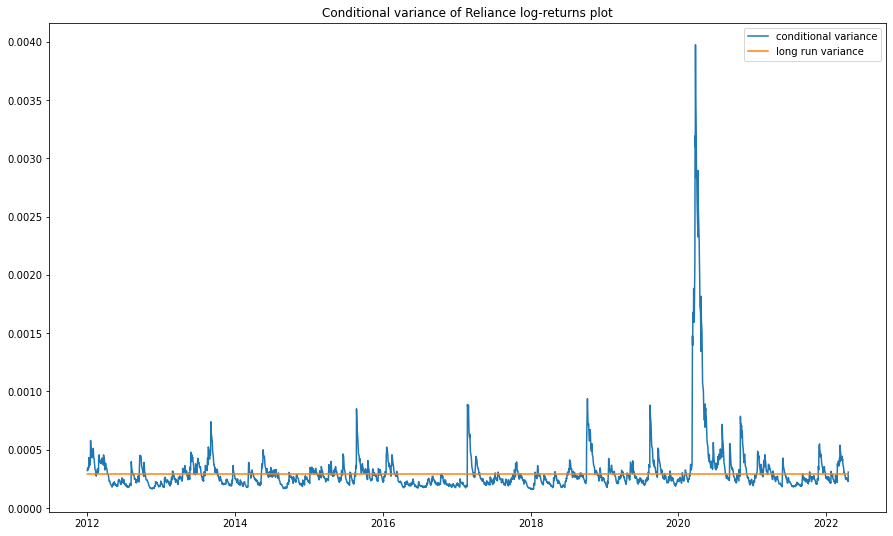

In [89]:
omega,a,b = res_t.x[0:3] ## estimated parameters 
long_term_variance = omega_t/((1-a_t-b_t))
figure(figsize=(15, 9))
plt.plot(data.index[1:],cond_variance_t)## cond_volatility plot with the std. residuals as Student's t distribution
plt.plot(data.index[1:],np.array([long_term_variance for i in range(len(data.index[1:]))]))
plt.legend(['conditional variance','long run variance'])
plt.title('Conditional variance of Reliance log-returns plot')
plt.savefig("Cond_variance.png")

Forecasting the volatilies for 50 days

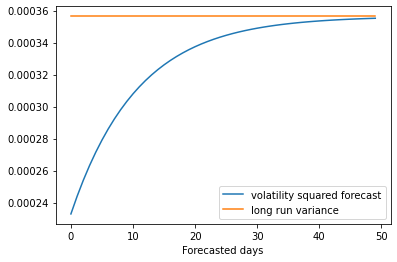

In [27]:
###Garch Forecast
N =50
omega,a,b = res_t.x[0:3] ## estimated parameters
omega = omega/10**(4) ## For estimation the returns were converted into percentage and thus the estimate of omega was scaled by 10000.
long_term_variance = omega/((1-a-b))
last_return = returns_data[-1]
last_vol_sq = cond_variance_t[-1]/10**(4) ## similarly obtained cond_volatility was also scaled by 10000 as percentage returns were used.
sq_vol_forecast = []
for j in range(N):  
    if j == 0:
        sq_vol_forecast.append(omega + a*(last_return)**2 + b*(last_vol_sq))
    else : sq_vol_forecast.append(omega + (a+b)*sq_vol_forecast[j-1])    
plt.plot(sq_vol_forecast)
plt.plot(np.array([long_term_variance for i in range(N)]))
plt.legend(['volatility squared forecast','long run variance'])
plt.xlabel("Forecasted days")
plt.show()